# Session 13

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [ ]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
! git config --global  pull.ff true
! git stash push --include-untracked
! git stash drop
! git pull

In [4]:
%cd S13/

/content/drive/MyDrive/Github/ERA-v1/S12


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [ ]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install pytorch_lightning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# del model

from Utilities.model import YOLOv3
from torchsummary import summary
from Utilities import config

# Model Initialization & Summary

In [3]:
model = YOLOv3(num_classes=config.NUM_CLASSES)

summary(model, input_size=(3, config.IMAGE_SIZE, config.IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          CNNBlock-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          CNNBlock-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         CNNBlock-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

# Dataset & Dataloaders

In [4]:
from Utilities.dataset import YOLODataModule

data_module = YOLODataModule(train_csv_path=config.DATASET + '/train.csv', 
                             test_csv_path=config.DATASET + "/test.csv")

# Training

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from Utilities.callbacks import PlotTestExamplesCallback, MAPCallback, CheckClassAccuracyCallback

trainer = pl.Trainer(
    max_epochs=40,
    accelerator=config.DEVICE,
    callbacks=[
        ModelCheckpoint(
            dirpath=config.CHECKPOINT_PATH,
            verbose=True,
        ),
        PlotTestExamplesCallback(every_n_epochs=3),
        CheckClassAccuracyCallback(train_every_n_epochs=1, test_every_n_epochs=3),
        MAPCallback(every_n_epochs=40),
        LearningRateMonitor(logging_interval='step', log_momentum=True),
    ],
    default_root_dir='Store/',
    precision=16,
)

/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,datamodule=data_module, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /Users/madhurjindal/WorkProjects/ERA-v1/S13/Store/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_

torch.Size([7, 3, 17, 17, 25]) torch.Size([7, 3, 13, 13, 6])


IndexError: The shape of the mask [7, 3, 13, 13] at index 2 does not match the shape of the indexed tensor [7, 3, 17, 17, 1] at index 2

/var/folders/_p/l4cqby956gg3nff31ksd975m0000gn/T/ipykernel_57323/494361915.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


new_lr=0.0025118864315095794


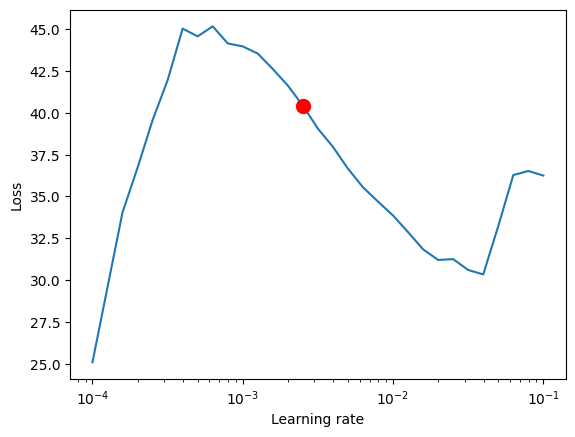

In [18]:
# Results can be found in
# print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [19]:
model.best_lr = 0.0025118864315095794

# Testing & Evaluation

1. Add on_train_end -> torch.save
2. Print LR
3. Check ERA conditions

/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /Users/madhurjindal/WorkProjects/ERA-v1/S13/Store/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 61.6 M
--------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
246.506   Total estimated model params size (MB)
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site

Epoch 3: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it, v_num=14, train_loss_step=86.00]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

Class accuracy is: 12.318841%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 3: 100%|██████████| 1/1 [00:13<00:00, 13.47s/it, v_num=14, train_loss_step=86.00, train_loss_epoch=86.00]

EPOCH: 3, Loss: 86.0203857421875
Epoch 4: 100%|██████████| 1/1 [00:05<00:00,  5.69s/it, v_num=14, train_loss_step=55.00, train_loss_epoch=86.00]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]

Class accuracy is: 8.571429%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 4: 100%|██████████| 1/1 [00:11<00:00, 11.59s/it, v_num=14, train_loss_step=55.00, train_loss_epoch=55.00]

EPOCH: 4, Loss: 55.031578063964844
Epoch 5: 100%|██████████| 1/1 [00:05<00:00,  5.23s/it, v_num=14, train_loss_step=131.0, train_loss_epoch=55.00]

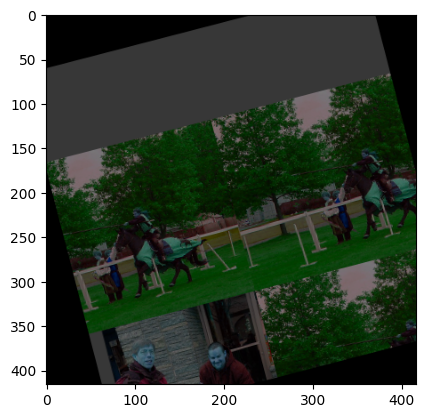

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


Class accuracy is: 28.985506%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:07<00:00,  3.64s/it]

Class accuracy is: 16.161615%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 5: 100%|██████████| 1/1 [00:24<00:00, 24.59s/it, v_num=14, train_loss_step=131.0, train_loss_epoch=131.0]

EPOCH: 5, Loss: 131.08621215820312
Epoch 6: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it, v_num=14, train_loss_step=38.10, train_loss_epoch=131.0]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]

Class accuracy is: 39.869282%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 6: 100%|██████████| 1/1 [00:13<00:00, 13.16s/it, v_num=14, train_loss_step=38.10, train_loss_epoch=38.10]

EPOCH: 6, Loss: 38.08694076538086
Epoch 7: 100%|██████████| 1/1 [00:05<00:00,  5.48s/it, v_num=14, train_loss_step=42.80, train_loss_epoch=38.10]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]

Class accuracy is: 35.119049%
No obj accuracy is: 4.689791%
Obj accuracy is: 66.666672%
Epoch 7: 100%|██████████| 1/1 [00:12<00:00, 12.31s/it, v_num=14, train_loss_step=42.80, train_loss_epoch=42.80]

EPOCH: 7, Loss: 42.76523208618164
Epoch 8: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it, v_num=14, train_loss_step=37.20, train_loss_epoch=42.80]

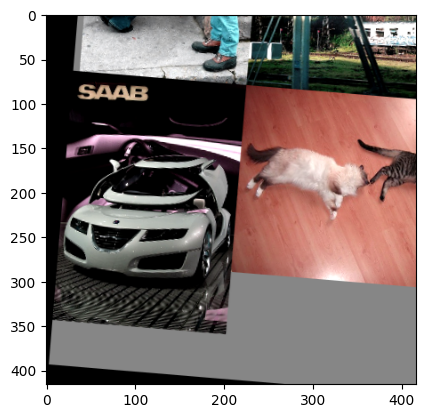

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Class accuracy is: 25.000000%
No obj accuracy is: 22.440361%
Obj accuracy is: 33.333336%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]

Class accuracy is: 11.653116%
No obj accuracy is: 22.449808%
Obj accuracy is: 36.043362%
Epoch 8: 100%|██████████| 1/1 [00:27<00:00, 27.05s/it, v_num=14, train_loss_step=37.20, train_loss_epoch=37.20]

EPOCH: 8, Loss: 37.244571685791016
Epoch 9: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it, v_num=14, train_loss_step=29.60, train_loss_epoch=37.20]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

Class accuracy is: 19.333332%
No obj accuracy is: 22.576742%
Obj accuracy is: 34.000000%
Epoch 9: 100%|██████████| 1/1 [00:14<00:00, 14.28s/it, v_num=14, train_loss_step=29.60, train_loss_epoch=29.60]

EPOCH: 9, Loss: 29.579111099243164
Epoch 10: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it, v_num=14, train_loss_step=27.40, train_loss_epoch=29.60]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:08<00:00,  8.05s/it]

Class accuracy is: 23.684212%
No obj accuracy is: 18.556549%
Obj accuracy is: 47.368423%
Epoch 10: 100%|██████████| 1/1 [00:15<00:00, 15.51s/it, v_num=14, train_loss_step=27.40, train_loss_epoch=27.40]

EPOCH: 10, Loss: 27.395214080810547
Epoch 11: 100%|██████████| 1/1 [00:09<00:00,  9.40s/it, v_num=14, train_loss_step=21.80, train_loss_epoch=27.40]

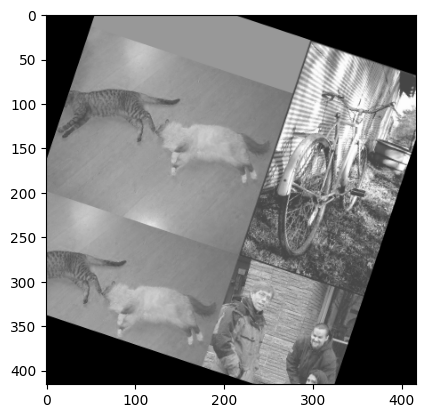

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


Class accuracy is: 40.151516%
No obj accuracy is: 3.380831%
Obj accuracy is: 95.454544%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:08<00:00,  4.44s/it]

Class accuracy is: 34.803921%
No obj accuracy is: 2.367010%
Obj accuracy is: 96.813728%
Epoch 11: 100%|██████████| 1/1 [00:32<00:00, 32.51s/it, v_num=14, train_loss_step=21.80, train_loss_epoch=21.80]

EPOCH: 11, Loss: 21.82845115661621
Epoch 12: 100%|██████████| 1/1 [00:06<00:00,  6.75s/it, v_num=14, train_loss_step=19.50, train_loss_epoch=21.80]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.77s/it]

Class accuracy is: 33.962265%
No obj accuracy is: 16.194881%
Obj accuracy is: 67.295601%
Epoch 12: 100%|██████████| 1/1 [00:14<00:00, 14.54s/it, v_num=14, train_loss_step=19.50, train_loss_epoch=19.50]

EPOCH: 12, Loss: 19.455402374267578
Epoch 13: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it, v_num=14, train_loss_step=21.80, train_loss_epoch=19.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:09<00:00,  9.69s/it]

Class accuracy is: 38.271606%
No obj accuracy is: 17.568113%
Obj accuracy is: 67.283951%
Epoch 13: 100%|██████████| 1/1 [00:16<00:00, 16.18s/it, v_num=14, train_loss_step=21.80, train_loss_epoch=21.80]

EPOCH: 13, Loss: 21.757680892944336
Epoch 14: 100%|██████████| 1/1 [00:06<00:00,  6.80s/it, v_num=14, train_loss_step=17.30, train_loss_epoch=21.80]

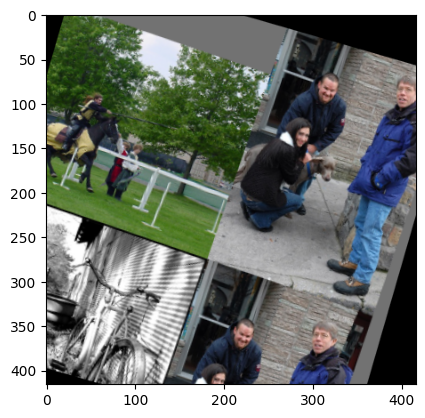

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Class accuracy is: 31.159418%
No obj accuracy is: 37.521175%
Obj accuracy is: 33.333336%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]

Class accuracy is: 22.431866%
No obj accuracy is: 37.065800%
Obj accuracy is: 45.073376%
Epoch 14: 100%|██████████| 1/1 [00:28<00:00, 28.91s/it, v_num=14, train_loss_step=17.30, train_loss_epoch=17.30]

EPOCH: 14, Loss: 17.260513305664062
Epoch 15: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it, v_num=14, train_loss_step=17.30, train_loss_epoch=17.30]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]

Class accuracy is: 24.074074%
No obj accuracy is: 84.469948%
Obj accuracy is: 33.333336%
Epoch 15: 100%|██████████| 1/1 [00:12<00:00, 12.63s/it, v_num=14, train_loss_step=17.30, train_loss_epoch=17.30]

EPOCH: 15, Loss: 17.328805923461914
Epoch 16: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it, v_num=14, train_loss_step=16.30, train_loss_epoch=17.30]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]

Class accuracy is: 32.592590%
No obj accuracy is: 85.884819%
Obj accuracy is: 33.333336%
Epoch 16: 100%|██████████| 1/1 [00:12<00:00, 12.69s/it, v_num=14, train_loss_step=16.30, train_loss_epoch=16.30]

EPOCH: 16, Loss: 16.296846389770508
Epoch 17: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it, v_num=14, train_loss_step=15.40, train_loss_epoch=16.30]

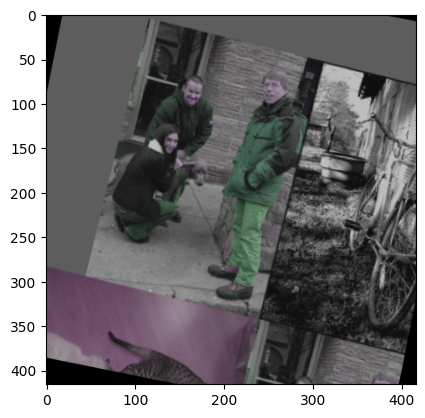

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


Class accuracy is: 41.509434%
No obj accuracy is: 86.801590%
Obj accuracy is: 33.962265%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]

Class accuracy is: 19.867550%
No obj accuracy is: 87.407379%
Obj accuracy is: 35.540840%
Epoch 17: 100%|██████████| 1/1 [00:28<00:00, 28.53s/it, v_num=14, train_loss_step=15.40, train_loss_epoch=15.40]

EPOCH: 17, Loss: 15.37175178527832
Epoch 18: 100%|██████████| 1/1 [00:06<00:00,  6.71s/it, v_num=14, train_loss_step=15.30, train_loss_epoch=15.40]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.38s/it]

Class accuracy is: 37.254902%
No obj accuracy is: 81.834068%
Obj accuracy is: 32.026146%
Epoch 18: 100%|██████████| 1/1 [00:14<00:00, 14.10s/it, v_num=14, train_loss_step=15.30, train_loss_epoch=15.30]

EPOCH: 18, Loss: 15.308595657348633
Epoch 19: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it, v_num=14, train_loss_step=13.60, train_loss_epoch=15.30]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:08<00:00,  8.12s/it]


Class accuracy is: 34.126984%
No obj accuracy is: 79.716927%
Obj accuracy is: 30.158731%


100%|██████████| 2/2 [02:26<00:00, 73.04s/it]


+++ MAP:  0.0
Epoch 20: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it, v_num=14, train_loss_step=13.20, train_loss_epoch=13.60] 

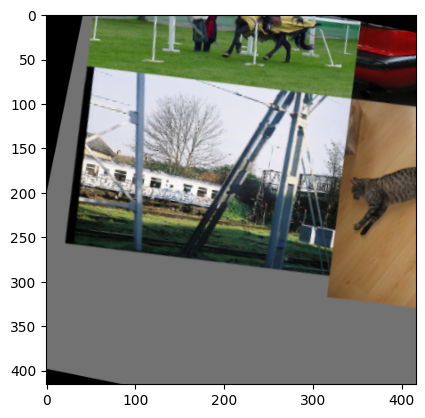

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


Class accuracy is: 33.333336%
No obj accuracy is: 80.582184%
Obj accuracy is: 23.129251%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]

Class accuracy is: 20.129869%
No obj accuracy is: 86.746666%
Obj accuracy is: 33.333336%
Epoch 20: 100%|██████████| 1/1 [00:25<00:00, 25.94s/it, v_num=14, train_loss_step=13.20, train_loss_epoch=13.20]

EPOCH: 20, Loss: 13.19487476348877
Epoch 21: 100%|██████████| 1/1 [00:05<00:00,  5.46s/it, v_num=14, train_loss_step=15.50, train_loss_epoch=13.20]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.99s/it]

Class accuracy is: 26.797386%
No obj accuracy is: 78.289635%
Obj accuracy is: 31.372551%
Epoch 21: 100%|██████████| 1/1 [00:12<00:00, 12.47s/it, v_num=14, train_loss_step=15.50, train_loss_epoch=15.50]

EPOCH: 21, Loss: 15.452006340026855
Epoch 22: 100%|██████████| 1/1 [00:05<00:00,  5.79s/it, v_num=14, train_loss_step=13.10, train_loss_epoch=15.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]

Class accuracy is: 34.640522%
No obj accuracy is: 75.168083%
Obj accuracy is: 33.986931%
Epoch 22: 100%|██████████| 1/1 [00:12<00:00, 12.40s/it, v_num=14, train_loss_step=13.10, train_loss_epoch=13.10]

EPOCH: 22, Loss: 13.12736988067627
Epoch 23: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it, v_num=14, train_loss_step=14.00, train_loss_epoch=13.10]

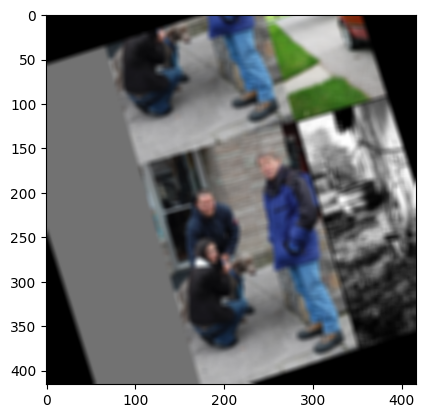

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


Class accuracy is: 23.717949%
No obj accuracy is: 80.109474%
Obj accuracy is: 29.487181%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]

Class accuracy is: 23.076923%
No obj accuracy is: 87.832054%
Obj accuracy is: 26.923079%
Epoch 23: 100%|██████████| 1/1 [00:29<00:00, 29.53s/it, v_num=14, train_loss_step=14.00, train_loss_epoch=14.00]

EPOCH: 23, Loss: 14.000601768493652
Epoch 24: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it, v_num=14, train_loss_step=14.30, train_loss_epoch=14.00]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

Class accuracy is: 34.591194%
No obj accuracy is: 76.960732%
Obj accuracy is: 34.591194%
Epoch 24: 100%|██████████| 1/1 [00:13<00:00, 13.53s/it, v_num=14, train_loss_step=14.30, train_loss_epoch=14.30]

EPOCH: 24, Loss: 14.277770042419434
Epoch 25: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it, v_num=14, train_loss_step=12.40, train_loss_epoch=14.30]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.62s/it]

Class accuracy is: 32.679741%
No obj accuracy is: 78.641350%
Obj accuracy is: 28.758171%
Epoch 25: 100%|██████████| 1/1 [00:13<00:00, 13.39s/it, v_num=14, train_loss_step=12.40, train_loss_epoch=12.40]

EPOCH: 25, Loss: 12.418648719787598
Epoch 26: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it, v_num=14, train_loss_step=12.40, train_loss_epoch=12.40]

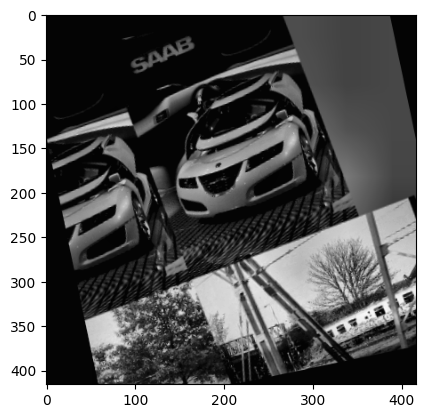

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


Class accuracy is: 32.000000%
No obj accuracy is: 84.256882%
Obj accuracy is: 28.000000%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:05<00:00,  2.87s/it]

Class accuracy is: 17.460318%
No obj accuracy is: 93.223282%
Obj accuracy is: 22.751322%
Epoch 26: 100%|██████████| 1/1 [00:27<00:00, 28.00s/it, v_num=14, train_loss_step=12.40, train_loss_epoch=12.40]

EPOCH: 26, Loss: 12.411458969116211
Epoch 27: 100%|██████████| 1/1 [00:05<00:00,  5.98s/it, v_num=14, train_loss_step=13.90, train_loss_epoch=12.40]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.17s/it]

Class accuracy is: 38.194447%
No obj accuracy is: 84.275764%
Obj accuracy is: 19.444445%
Epoch 27: 100%|██████████| 1/1 [00:13<00:00, 13.16s/it, v_num=14, train_loss_step=13.90, train_loss_epoch=13.90]

EPOCH: 27, Loss: 13.930933952331543
Epoch 28: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it, v_num=14, train_loss_step=12.30, train_loss_epoch=13.90]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]

Class accuracy is: 34.640522%
No obj accuracy is: 82.467865%
Obj accuracy is: 22.875816%
Epoch 28: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it, v_num=14, train_loss_step=12.30, train_loss_epoch=12.30]

EPOCH: 28, Loss: 12.334707260131836
Epoch 29: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it, v_num=14, train_loss_step=12.50, train_loss_epoch=12.30]

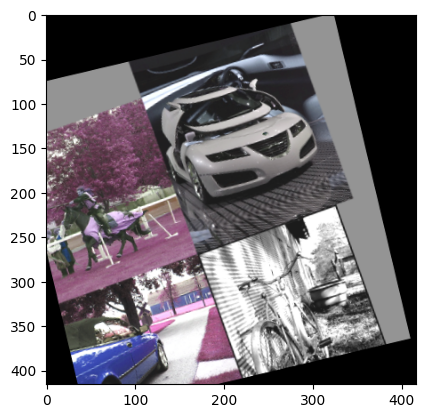

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


Class accuracy is: 43.169399%
No obj accuracy is: 84.448776%
Obj accuracy is: 16.939890%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]

Class accuracy is: 21.911421%
No obj accuracy is: 95.991180%
Obj accuracy is: 13.053613%
Epoch 29: 100%|██████████| 1/1 [00:28<00:00, 28.63s/it, v_num=14, train_loss_step=12.50, train_loss_epoch=12.50]

EPOCH: 29, Loss: 12.516373634338379
Epoch 30: 100%|██████████| 1/1 [00:05<00:00,  5.98s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=12.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

Class accuracy is: 42.138367%
No obj accuracy is: 84.366592%
Obj accuracy is: 8.805032%
Epoch 30: 100%|██████████| 1/1 [00:13<00:00, 13.35s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=11.50]

EPOCH: 30, Loss: 11.51750659942627
Epoch 31: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it, v_num=14, train_loss_step=13.70, train_loss_epoch=11.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.45s/it]

Class accuracy is: 43.274853%
No obj accuracy is: 83.168800%
Obj accuracy is: 16.374269%
Epoch 31: 100%|██████████| 1/1 [00:14<00:00, 14.20s/it, v_num=14, train_loss_step=13.70, train_loss_epoch=13.70]

EPOCH: 31, Loss: 13.68604564666748
Epoch 32: 100%|██████████| 1/1 [00:06<00:00,  6.69s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=13.70]

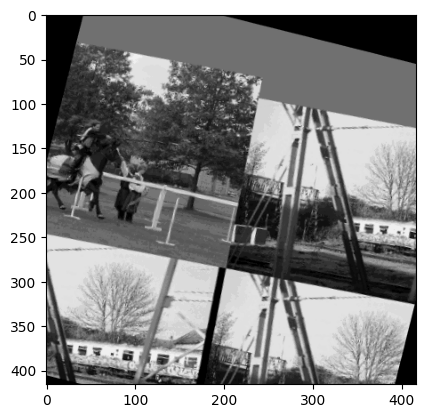

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


Class accuracy is: 41.025642%
No obj accuracy is: 82.297882%
Obj accuracy is: 21.153847%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]

Class accuracy is: 22.307692%
No obj accuracy is: 95.926750%
Obj accuracy is: 4.358974%
Epoch 32: 100%|██████████| 1/1 [00:28<00:00, 28.05s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=11.50]

EPOCH: 32, Loss: 11.472731590270996
Epoch 33: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it, v_num=14, train_loss_step=12.20, train_loss_epoch=11.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]

Class accuracy is: 43.859650%
No obj accuracy is: 88.578461%
Obj accuracy is: 3.508772%
Epoch 33: 100%|██████████| 1/1 [00:13<00:00, 13.10s/it, v_num=14, train_loss_step=12.20, train_loss_epoch=12.20]

EPOCH: 33, Loss: 12.238821983337402
Epoch 34: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it, v_num=14, train_loss_step=11.90, train_loss_epoch=12.20]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:08<00:00,  8.94s/it]

Class accuracy is: 42.962963%
No obj accuracy is: 87.392792%
Obj accuracy is: 5.185185%
Epoch 34: 100%|██████████| 1/1 [00:15<00:00, 15.44s/it, v_num=14, train_loss_step=11.90, train_loss_epoch=11.90]

EPOCH: 34, Loss: 11.923738479614258
Epoch 35: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it, v_num=14, train_loss_step=11.80, train_loss_epoch=11.90]

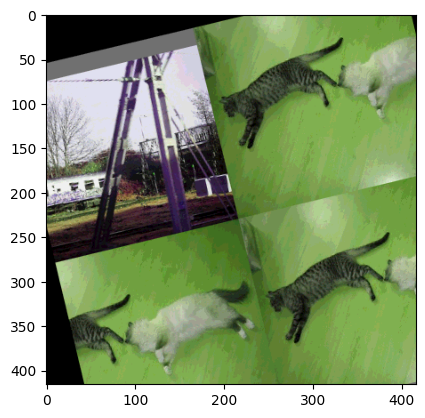

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:08<00:00,  8.25s/it]


Class accuracy is: 42.000000%
No obj accuracy is: 87.872963%
Obj accuracy is: 4.666667%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]

Class accuracy is: 21.645021%
No obj accuracy is: 96.249809%
Obj accuracy is: 5.411255%
Epoch 35: 100%|██████████| 1/1 [00:28<00:00, 28.24s/it, v_num=14, train_loss_step=11.80, train_loss_epoch=11.80]

EPOCH: 35, Loss: 11.788578987121582
Epoch 36: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it, v_num=14, train_loss_step=13.00, train_loss_epoch=11.80]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

Class accuracy is: 38.993710%
No obj accuracy is: 91.306160%
Obj accuracy is: 5.031446%
Epoch 36: 100%|██████████| 1/1 [00:13<00:00, 13.87s/it, v_num=14, train_loss_step=13.00, train_loss_epoch=13.00]

EPOCH: 36, Loss: 13.045613288879395
Epoch 37: 100%|██████████| 1/1 [00:06<00:00,  6.21s/it, v_num=14, train_loss_step=13.20, train_loss_epoch=13.00]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:08<00:00,  8.93s/it]

Class accuracy is: 43.410854%
No obj accuracy is: 93.288528%
Obj accuracy is: 2.325581%
Epoch 37: 100%|██████████| 1/1 [00:15<00:00, 15.15s/it, v_num=14, train_loss_step=13.20, train_loss_epoch=13.20]

EPOCH: 37, Loss: 13.203387260437012
Epoch 38: 100%|██████████| 1/1 [00:07<00:00,  7.18s/it, v_num=14, train_loss_step=10.30, train_loss_epoch=13.20]

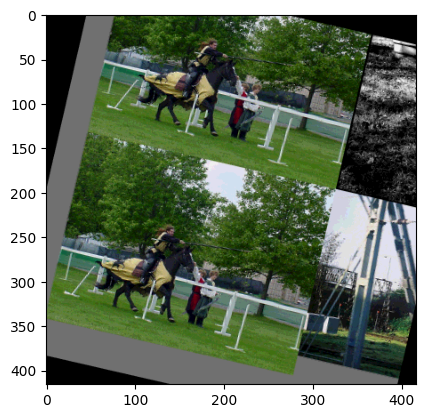

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Class accuracy is: 47.457626%
No obj accuracy is: 92.208984%
Obj accuracy is: 4.519774%
+++ TEST ACCURACIES


100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

Class accuracy is: 22.792023%
No obj accuracy is: 96.767441%
Obj accuracy is: 4.273504%
Epoch 38: 100%|██████████| 1/1 [00:28<00:00, 28.97s/it, v_num=14, train_loss_step=10.30, train_loss_epoch=10.30]

EPOCH: 38, Loss: 10.280192375183105
Epoch 39: 100%|██████████| 1/1 [00:07<00:00,  7.59s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=10.30]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


Class accuracy is: 37.878788%
No obj accuracy is: 94.418976%
Obj accuracy is: 3.030303%


100%|██████████| 2/2 [00:59<00:00, 29.69s/it]


+++ MAP:  6.560858764714794e-06
Epoch 39: 100%|██████████| 1/1 [01:23<00:00, 83.98s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=11.50]EPOCH: 39, Loss: 11.523896217346191


`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 1/1 [01:27<00:00, 87.06s/it, v_num=14, train_loss_step=11.50, train_loss_epoch=11.50]


In [21]:
trainer.fit(model=model, datamodule=data_module)

### Git Push

In [22]:
! git remote set-url origin git@github.com:Madhur-1/ERA-v1.git
! git add .
# ! git commit -m "S12 commit 92.31%"
! git push

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
